In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Load and Merge the data

In [2]:
application_data=pd.read_csv("data/application_data.csv")
previous_application=pd.read_csv("data/previous_application.csv")

In [3]:
# Merge application_data and previous_application_data
merged_data = pd.merge(application_data, previous_application, on='SK_ID_CURR', how='left')

In [4]:
print(list(merged_data.columns))

['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE_x', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT_x', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'NAME_TYPE_SUITE_x', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START_x', 'HOUR_APPR_PROCESS_START_x', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONA

Client Profile Analysis

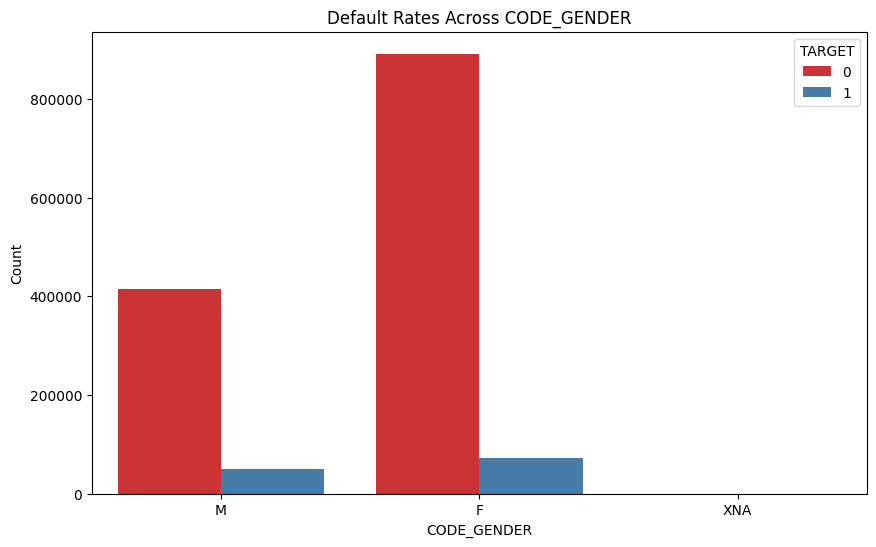

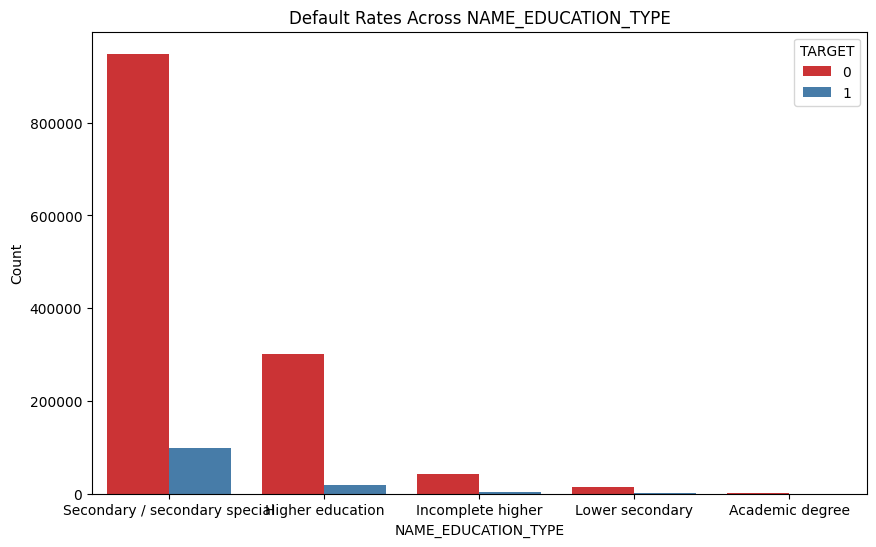

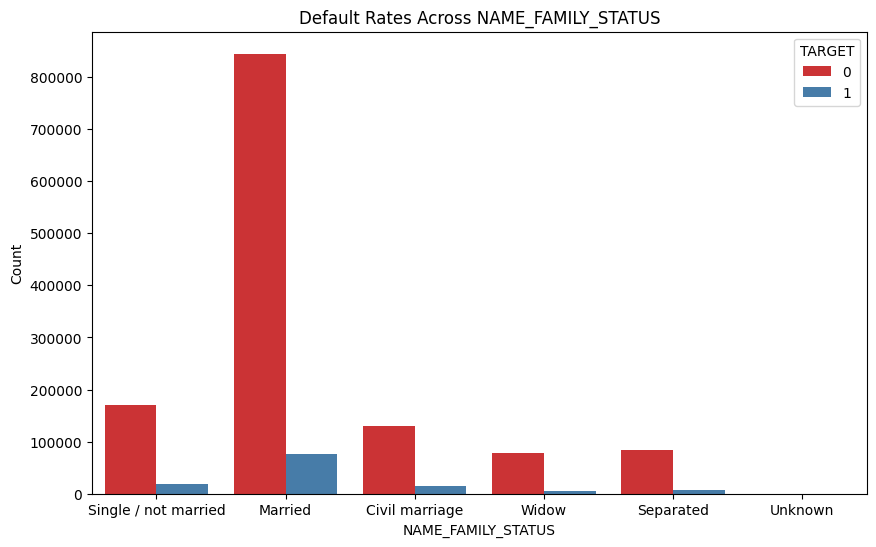

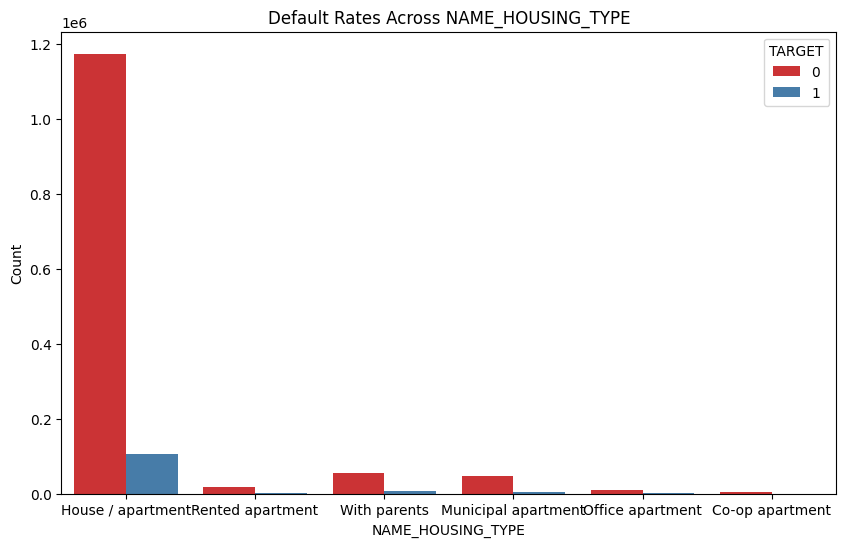

In [5]:
# Default rates across different demographic groups
demographic_groups = ['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']

for group in demographic_groups:
    plt.figure(figsize=(10,6))
    sns.countplot(x=group,hue='TARGET',data=merged_data,palette='Set1')
    plt.title(f'Default Rates Across {group}')
    plt.xlabel(group)
    plt.ylabel('Count')
    plt.show()


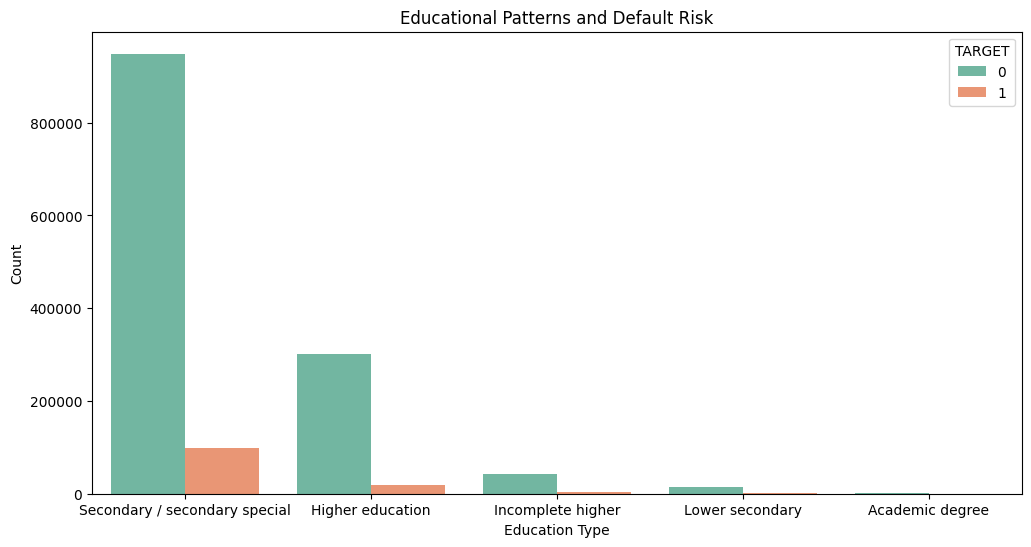

In [6]:
# Educational patterns associated with higher default risk
plt.figure(figsize=(12,6))
sns.countplot(x='NAME_EDUCATION_TYPE',hue='TARGET',data=merged_data,palette='Set2')
plt.title('Educational Patterns and Default Risk')
plt.xlabel('Education Type')
plt.ylabel('Count')
plt.show()

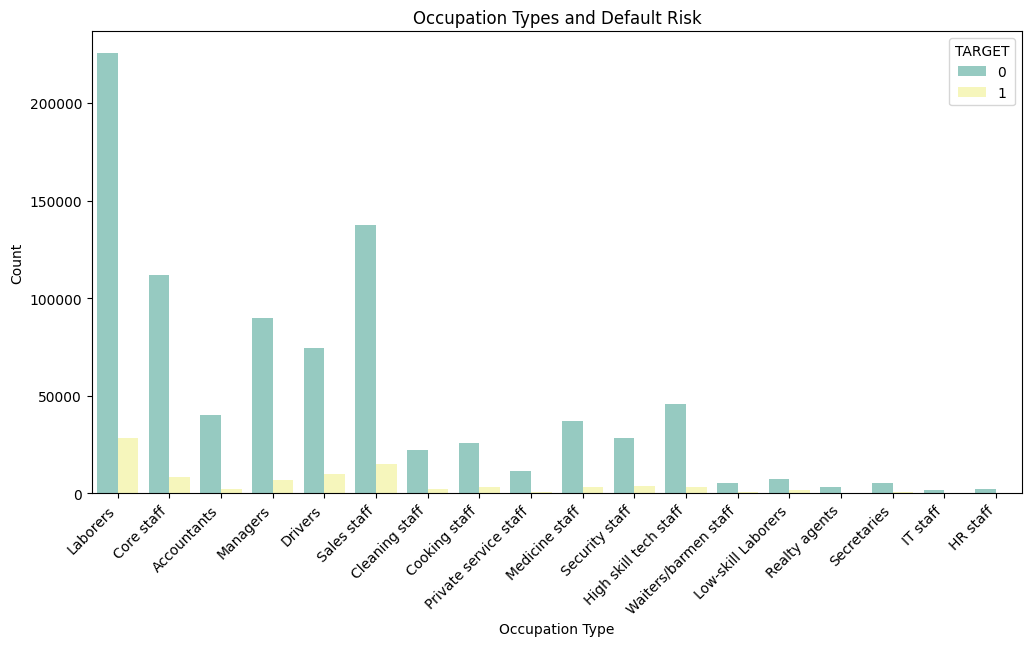

In [7]:
# Employment patterns associated with higher default risk
plt.figure(figsize=(12, 6))
sns.countplot(x='OCCUPATION_TYPE', hue='TARGET', data=merged_data, palette='Set3')
plt.title('Occupation Types and Default Risk')
plt.xlabel('Occupation Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_13640\863450066.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y='AMT_INCOME_TOTAL', data=merged_data, palette='pastel')


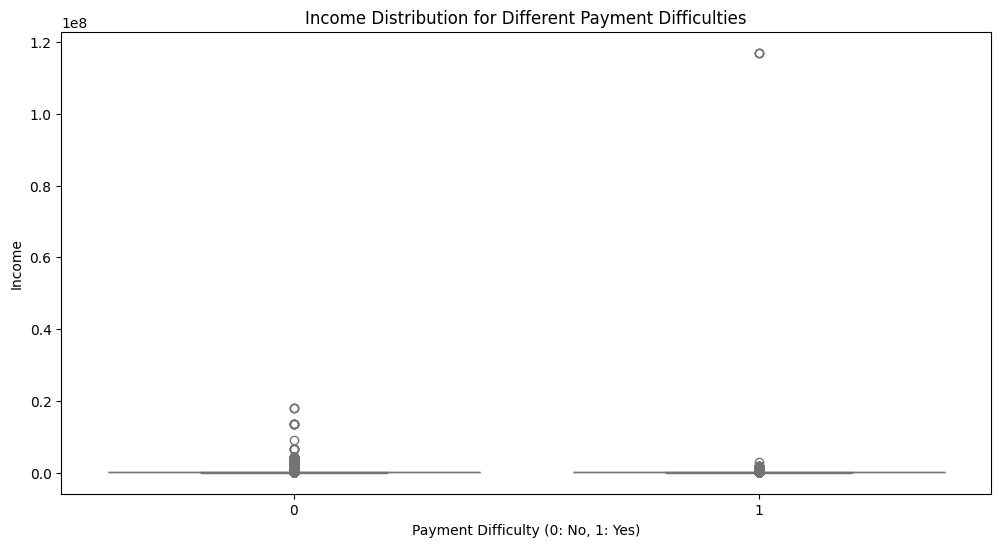

In [8]:
# Differences in client profiles between those with payment difficulties and those without
plt.figure(figsize=(12, 6))
sns.boxplot(x='TARGET', y='AMT_INCOME_TOTAL', data=merged_data, palette='pastel')
plt.title('Income Distribution for Different Payment Difficulties')
plt.xlabel('Payment Difficulty (0: No, 1: Yes)')
plt.ylabel('Income')
plt.show()

In [9]:
# Calculate Income to Debt ratio
merged_data['INCOME_TO_DEBT_RATIO'] = merged_data['AMT_INCOME_TOTAL'] / merged_data['AMT_CREDIT_x']

# Display the calculated ratio
print("Income to Debt Ratio:")
print(merged_data[['SK_ID_CURR', 'INCOME_TO_DEBT_RATIO']])

Income to Debt Ratio:
         SK_ID_CURR  INCOME_TO_DEBT_RATIO
0            100002              0.498036
1            100003              0.208736
2            100003              0.208736
3            100003              0.208736
4            100004              0.500000
...             ...                   ...
1430150      456255              0.233333
1430151      456255              0.233333
1430152      456255              0.233333
1430153      456255              0.233333
1430154      456255              0.233333

[1430155 rows x 2 columns]


Financial Analysis

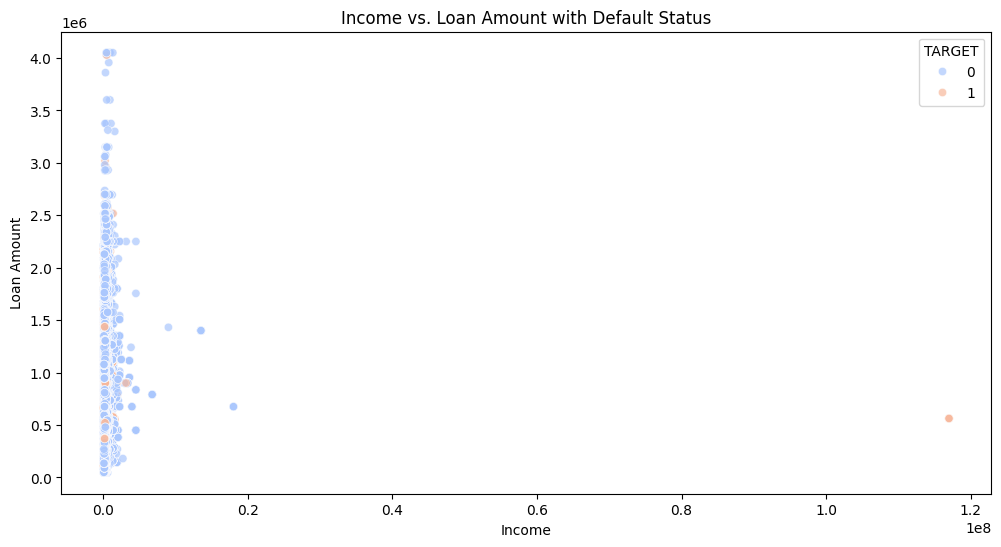

In [10]:
# Relationship between income, debt levels, and loan default probability
plt.figure(figsize=(12, 6))
sns.scatterplot(x='AMT_INCOME_TOTAL', y='AMT_CREDIT_x', hue='TARGET', data=merged_data, palette='coolwarm', alpha=0.7)
plt.title('Income vs. Loan Amount with Default Status')
plt.xlabel('Income')
plt.ylabel('Loan Amount')
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_13640\3882810402.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(merged_data.loc[merged_data['TARGET'] == 0, 'AMT_INCOME_TOTAL'], label='No Default', shade=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_13640\3882810402.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(merged_data.loc[merged_data['TARGET'] == 1, 'AMT_INCOME_TOTAL'], label='Default', shade=True)


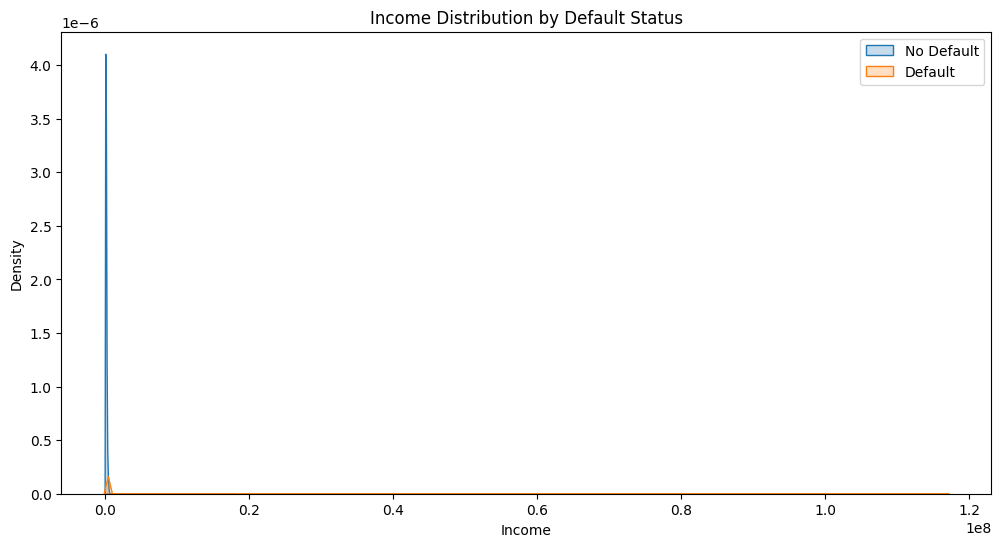

In [11]:
# Income distribution among loan applicants and its influence on loan amounts and approval rates
plt.figure(figsize=(12, 6))
sns.kdeplot(merged_data.loc[merged_data['TARGET'] == 0, 'AMT_INCOME_TOTAL'], label='No Default', shade=True)
sns.kdeplot(merged_data.loc[merged_data['TARGET'] == 1, 'AMT_INCOME_TOTAL'], label='Default', shade=True)
plt.title('Income Distribution by Default Status')
plt.xlabel('Income')
plt.ylabel('Density')
plt.legend()
plt.show()

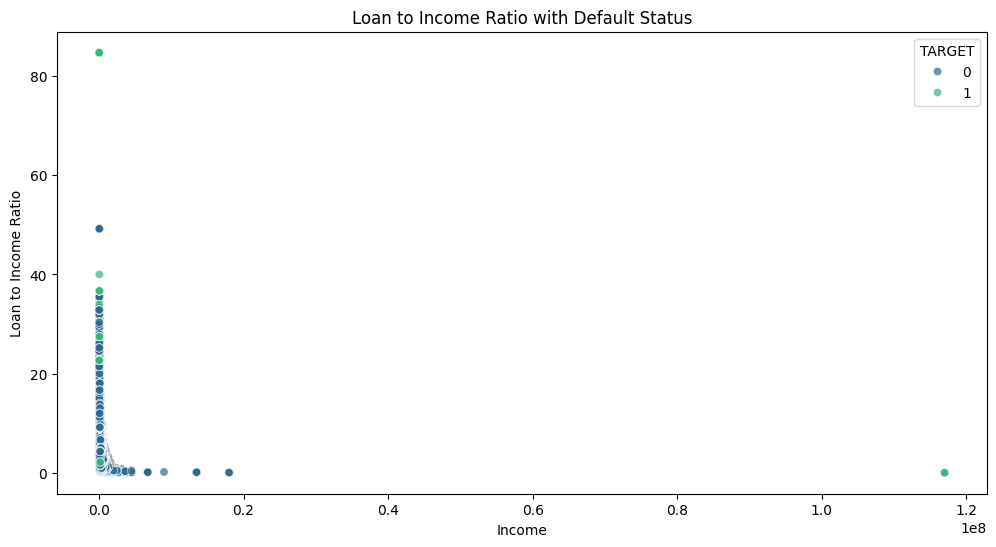

In [12]:
# Loan amount requested compared to income levels and its impact on default rates
merged_data['LOAN_TO_INCOME_RATIO'] = merged_data['AMT_CREDIT_x'] / merged_data['AMT_INCOME_TOTAL']

plt.figure(figsize=(12, 6))
sns.scatterplot(x='AMT_INCOME_TOTAL', y='LOAN_TO_INCOME_RATIO', hue='TARGET', data=merged_data, palette='viridis', alpha=0.7)
plt.title('Loan to Income Ratio with Default Status')
plt.xlabel('Income')
plt.ylabel('Loan to Income Ratio')
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_13640\788985182.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(merged_data.loc[merged_data['TARGET'] == 0, 'LOAN_TO_INCOME_RATIO'], label='No Default', shade=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_13640\788985182.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(merged_data.loc[merged_data['TARGET'] == 1, 'LOAN_TO_INCOME_RATIO'], label='Default', shade=True)


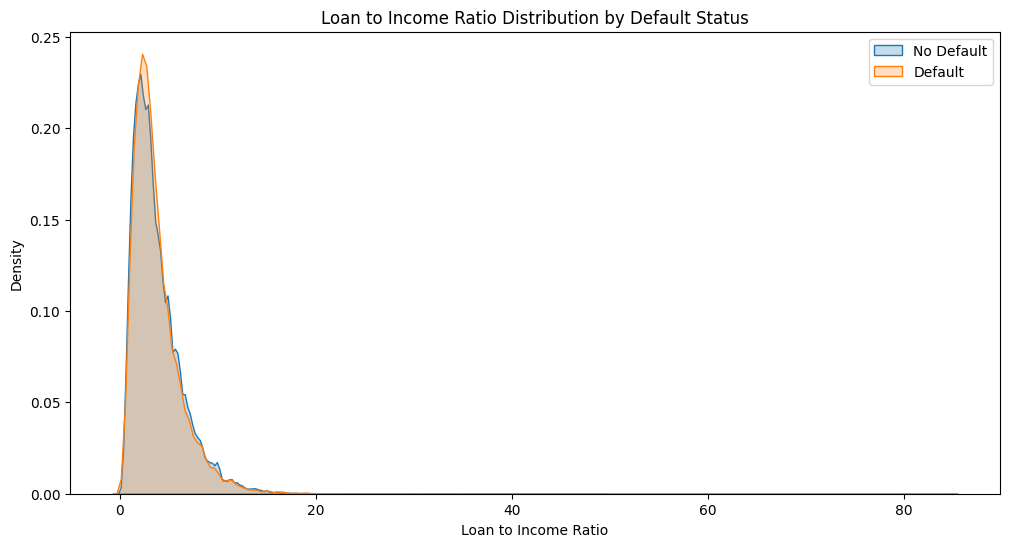

In [13]:
# Analysis of loan amount requested compared to income levels and its impact on default rates
plt.figure(figsize=(12, 6))
sns.kdeplot(merged_data.loc[merged_data['TARGET'] == 0, 'LOAN_TO_INCOME_RATIO'], label='No Default', shade=True)
sns.kdeplot(merged_data.loc[merged_data['TARGET'] == 1, 'LOAN_TO_INCOME_RATIO'], label='Default', shade=True)
plt.title('Loan to Income Ratio Distribution by Default Status')
plt.xlabel('Loan to Income Ratio')
plt.ylabel('Density')
plt.legend()
plt.show()

Credit History Analysis

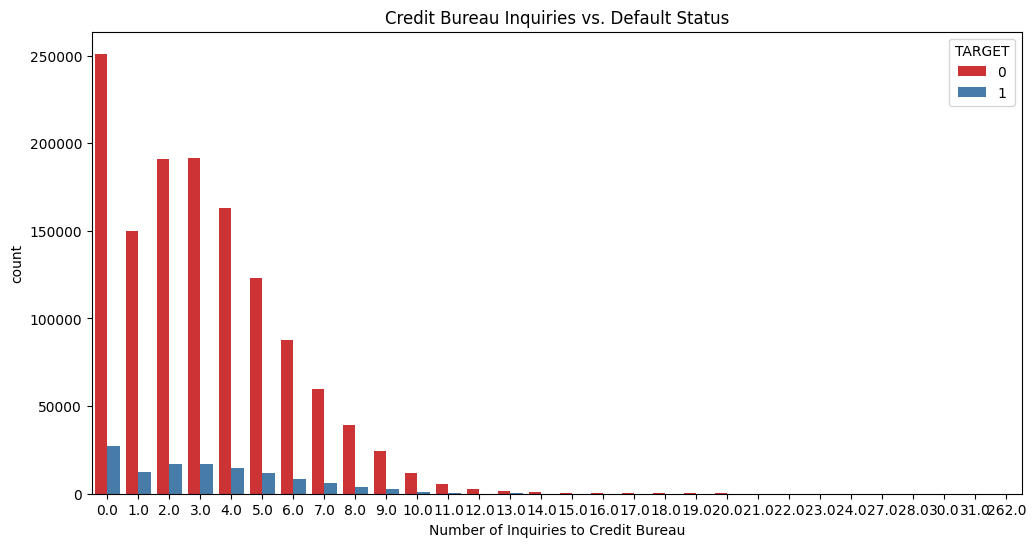

In [14]:
# Calculate the total number of credit bureau inquiries
merged_data['AMT_REQ_CREDIT_BUREAU_TOTAL'] = merged_data[['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']].sum(axis=1)

# Visualize the impact
plt.figure(figsize=(12, 6))
sns.countplot(x='AMT_REQ_CREDIT_BUREAU_TOTAL', hue='TARGET', data=merged_data, palette='Set1')
plt.title('Credit Bureau Inquiries vs. Default Status')
plt.xlabel('Number of Inquiries to Credit Bureau')
plt.show()

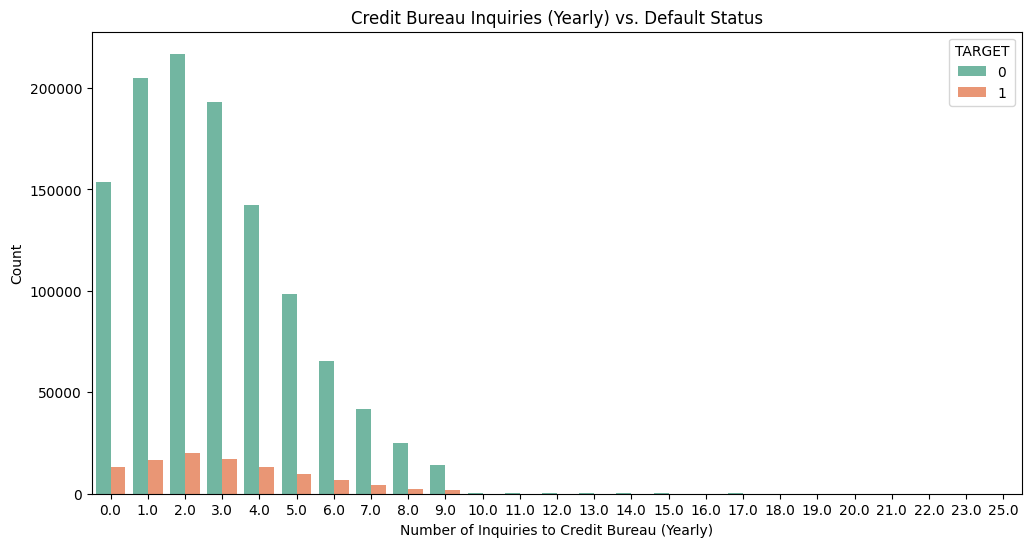

In [15]:
# Impact of past defaults on creditworthiness
plt.figure(figsize=(12, 6))
sns.countplot(x='AMT_REQ_CREDIT_BUREAU_YEAR', hue='TARGET', data=merged_data, palette='Set2')
plt.title('Credit Bureau Inquiries (Yearly) vs. Default Status')
plt.xlabel('Number of Inquiries to Credit Bureau (Yearly)')
plt.ylabel('Count')
plt.show()

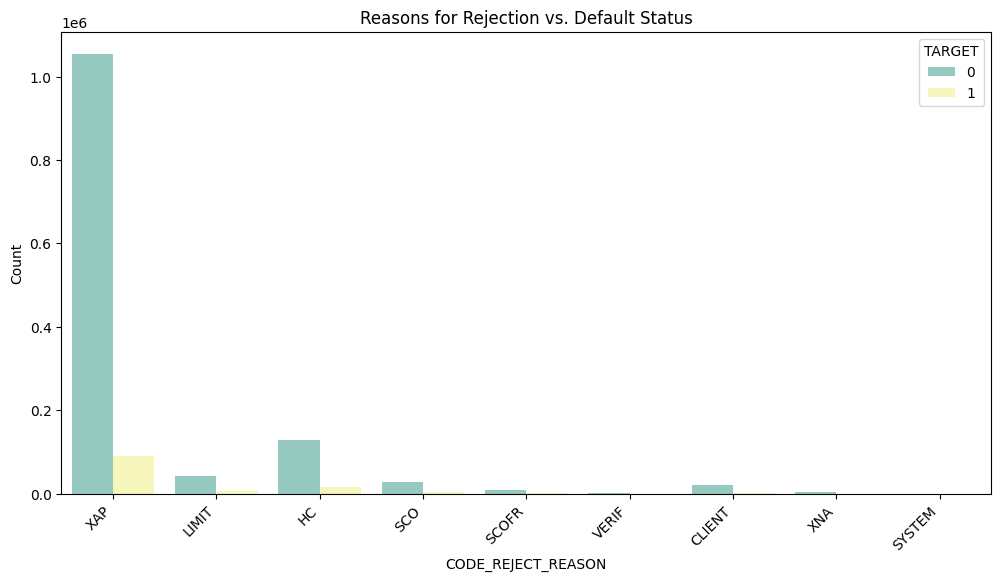

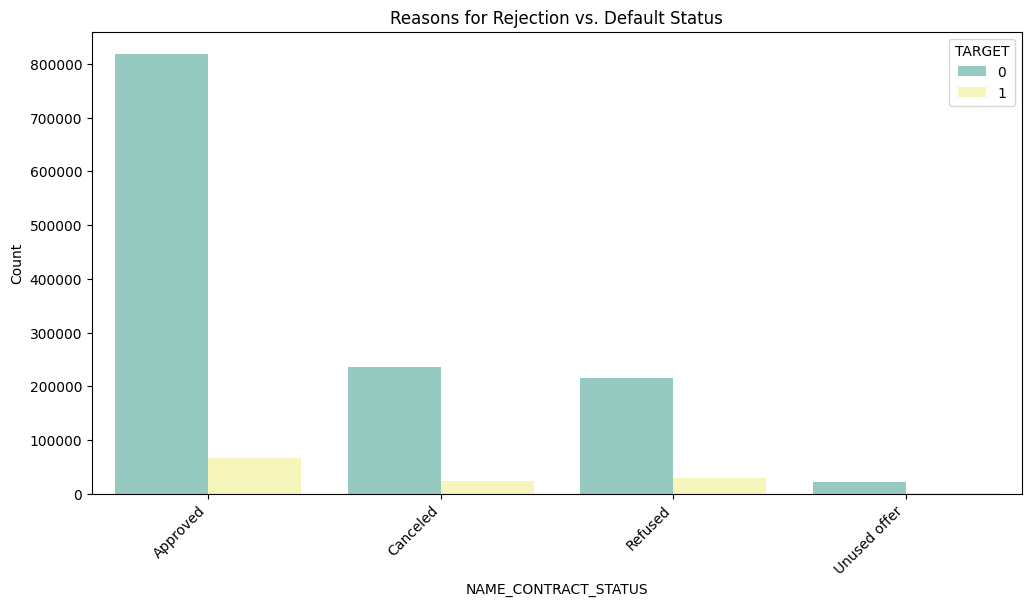

In [16]:
# Relationships between credit risk and reasons for rejection of previous loan application
rejection_reasons = ['CODE_REJECT_REASON', 'NAME_CONTRACT_STATUS']

for reason in rejection_reasons:
    plt.figure(figsize=(12, 6))
    sns.countplot(x=reason, hue='TARGET', data=merged_data, palette='Set3')
    plt.title(f'Reasons for Rejection vs. Default Status')
    plt.xlabel(reason)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.show()

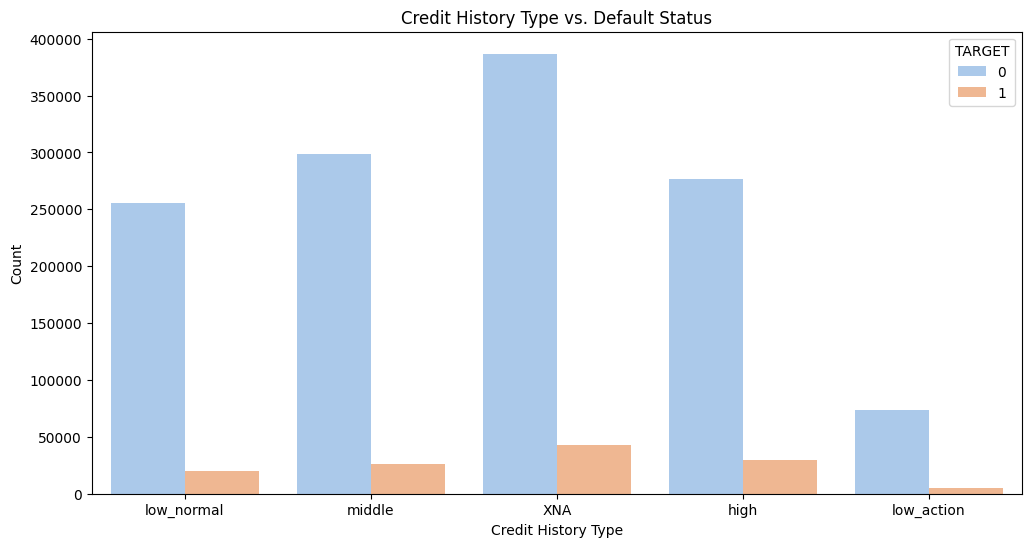

In [17]:
# Type of credit history vs. default risk assessment
plt.figure(figsize=(12, 6))
sns.countplot(x='NAME_YIELD_GROUP', hue='TARGET', data=merged_data, palette='pastel')
plt.title('Credit History Type vs. Default Status')
plt.xlabel('Credit History Type')
plt.ylabel('Count')
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_13640\771530373.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='DAYS_DECISION', y='TARGET', data=merged_data, palette='pastel', orient='h')


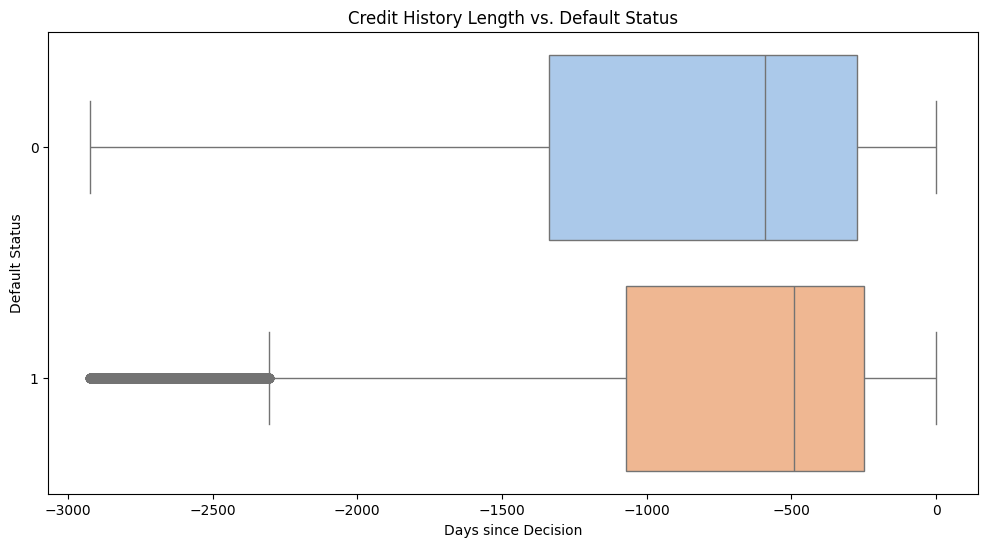

In [18]:
# Length of credit history vs. default risk assessment
plt.figure(figsize=(12, 6))
sns.boxplot(x='DAYS_DECISION', y='TARGET', data=merged_data, palette='pastel', orient='h')
plt.title('Credit History Length vs. Default Status')
plt.xlabel('Days since Decision')
plt.ylabel('Default Status')
plt.show()


Loan Application Decision Analysis

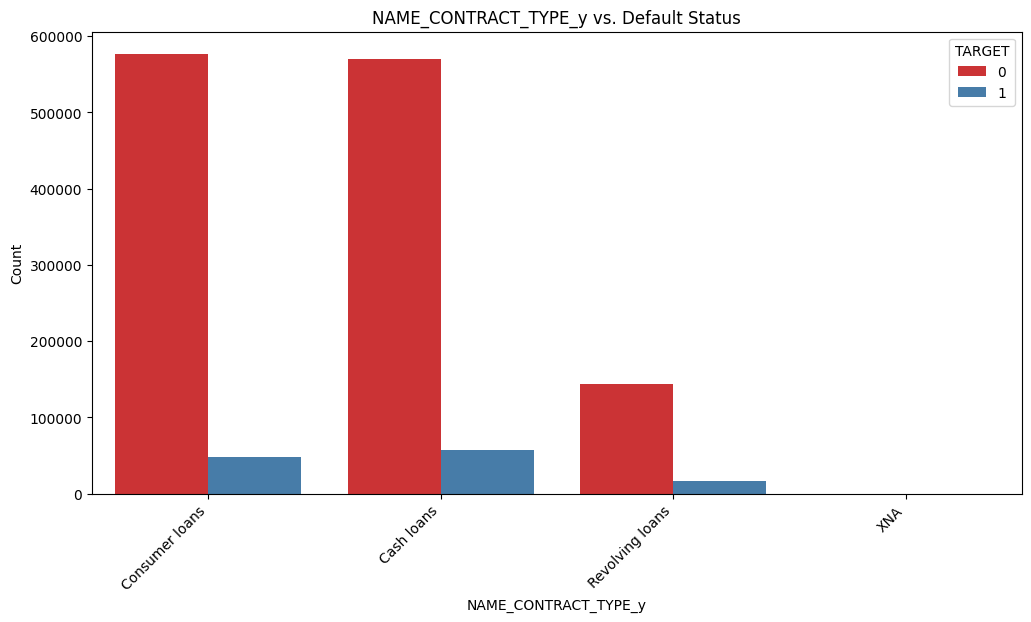

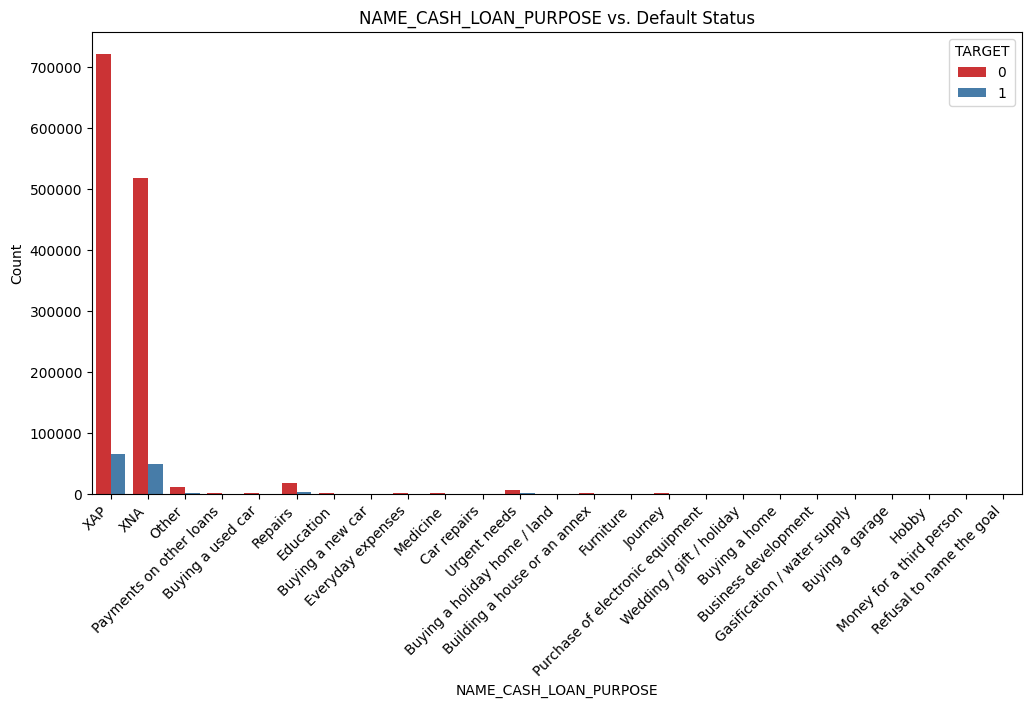

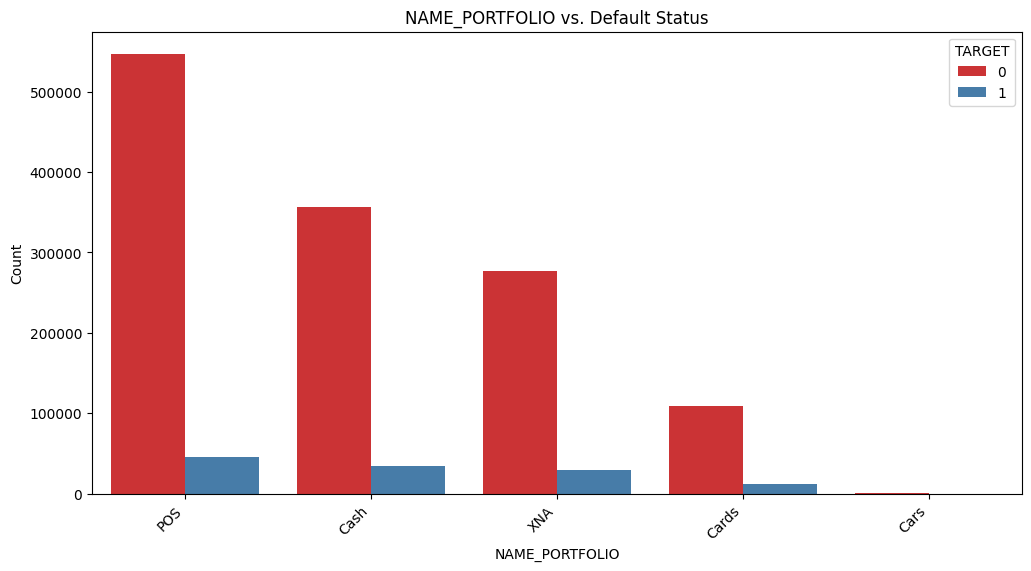

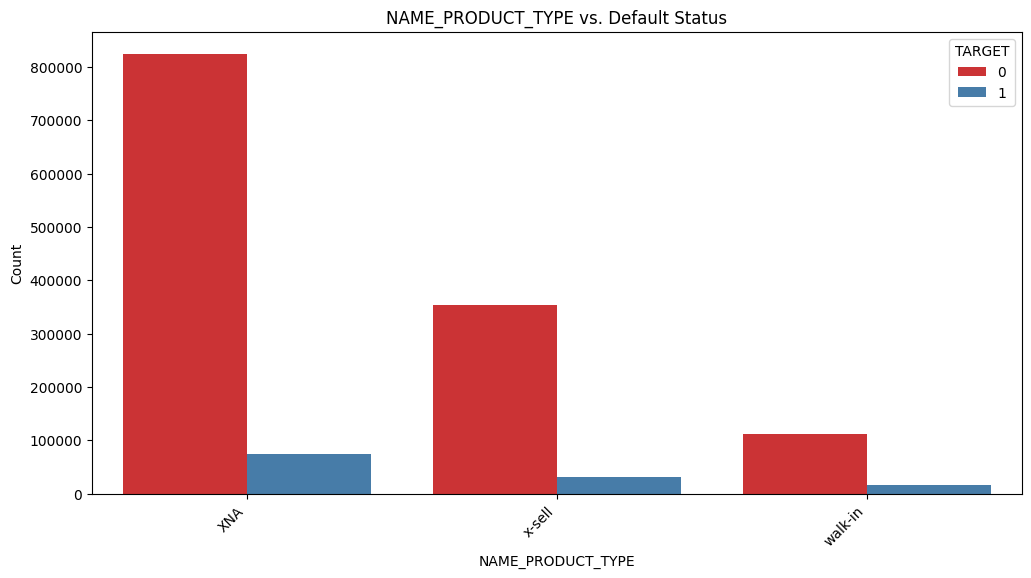

In [19]:
# Correlation between loan types, amounts, or purposes and default risk
loan_types = ['NAME_CONTRACT_TYPE_y', 'NAME_CASH_LOAN_PURPOSE', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE']

for loan_type in loan_types:
    plt.figure(figsize=(12, 6))
    sns.countplot(x=loan_type, hue='TARGET', data=merged_data, palette='Set1')
    plt.title(f'{loan_type} vs. Default Status')
    plt.xlabel(loan_type)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.show()

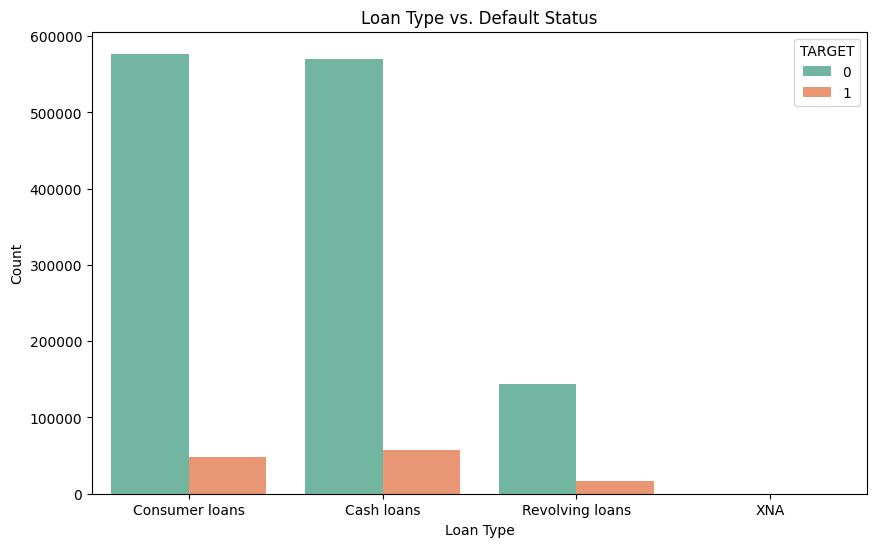

In [20]:
# Differences in approval rates between different types of loans (cash vs. revolving)
plt.figure(figsize=(10, 6))
sns.countplot(x='NAME_CONTRACT_TYPE_y', hue='TARGET', data=merged_data, palette='Set2')
plt.title('Loan Type vs. Default Status')
plt.xlabel('Loan Type')
plt.ylabel('Count')
plt.show()

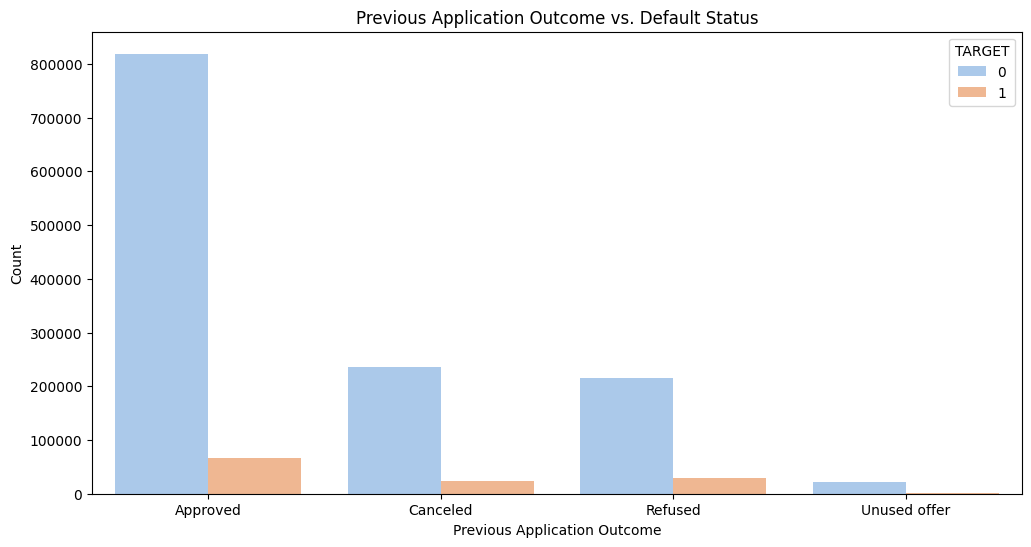

In [21]:
# Previous application outcomes affecting future default risk
plt.figure(figsize=(12, 6))
sns.countplot(x='NAME_CONTRACT_STATUS', hue='TARGET', data=merged_data, palette='pastel')
plt.title('Previous Application Outcome vs. Default Status')
plt.xlabel('Previous Application Outcome')
plt.ylabel('Count')
plt.show()

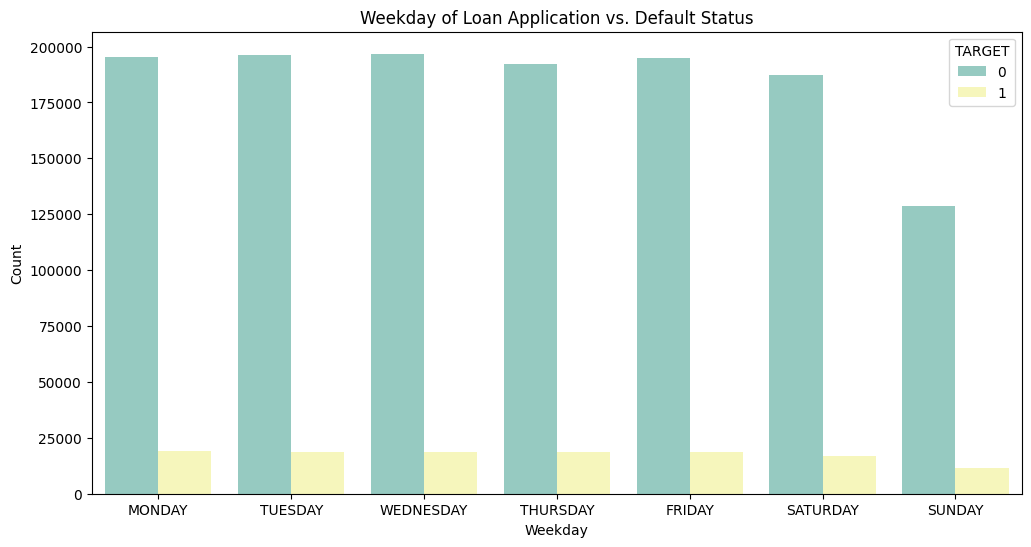

In [22]:
# Correlations between the client's credit risk and the weekday they applied for the loan
plt.figure(figsize=(12, 6))
sns.countplot(x='WEEKDAY_APPR_PROCESS_START_y', hue='TARGET', data=merged_data, palette='Set3', order=['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY', 'SATURDAY', 'SUNDAY'])
plt.title('Weekday of Loan Application vs. Default Status')
plt.xlabel('Weekday')
plt.ylabel('Count')
plt.show()

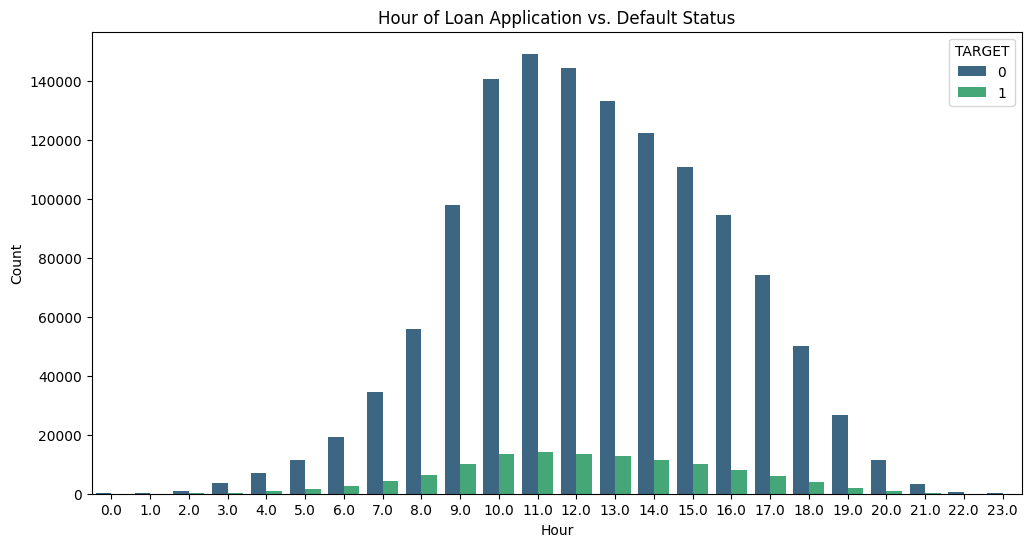

In [23]:
# Correlations between the client's credit risk and the hour they applied for the loan
plt.figure(figsize=(12, 6))
sns.countplot(x='HOUR_APPR_PROCESS_START_y', hue='TARGET', data=merged_data, palette='viridis')
plt.title('Hour of Loan Application vs. Default Status')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.show()

Feature Importance Analysis

In [24]:
# Select relevant features for training the model
selected_features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT_x', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
                     'AMT_REQ_CREDIT_BUREAU_TOTAL', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'NAME_CONTRACT_TYPE_x', 'NAME_CASH_LOAN_PURPOSE',
                     'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'NAME_CONTRACT_STATUS', 'WEEKDAY_APPR_PROCESS_START_y', 'HOUR_APPR_PROCESS_START_y',
                     'NAME_YIELD_GROUP', 'DAYS_DECISION', 'LOAN_TO_INCOME_RATIO']

X = merged_data[selected_features]
y = merged_data['TARGET']

# Data preprocessing - handle missing values, convert categorical variables, etc.
X.fillna(0, inplace=True)  # Replace missing values with 0 for simplicity
X = pd.get_dummies(X)  # One-hot encode categorical variables if any

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top features
print("Top Features and Their Importance:")
print(feature_importance_df.head(10))

# Make predictions on the test set for further analysis
y_pred = model.predict(X_test)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

C:\Users\HP\AppData\Local\Temp\ipykernel_13640\778696200.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)  # Replace missing values with 0 for simplicity


Top Features and Their Importance:
                      Feature  Importance
5                EXT_SOURCE_2    0.115900
2                  DAYS_BIRTH    0.095869
6                EXT_SOURCE_3    0.094788
11       LOAN_TO_INCOME_RATIO    0.089540
1                AMT_CREDIT_x    0.083992
3               DAYS_EMPLOYED    0.083248
10              DAYS_DECISION    0.076023
0            AMT_INCOME_TOTAL    0.065958
4                EXT_SOURCE_1    0.053652
9   HOUR_APPR_PROCESS_START_y    0.049360

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97    261296
           1       1.00      0.28      0.44     24735

    accuracy                           0.94    286031
   macro avg       0.97      0.64      0.71    286031
weighted avg       0.94      0.94      0.92    286031



Portfolio and Risk Assessment

1. Segmenting Clients Based on Risk Profiles:

In [25]:
# Create risk profiles based on credit risk features
risk_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_CREDIT_x', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH']

C:\Users\HP\AppData\Local\Temp\ipykernel_13640\1932879553.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='RISK_PROFILE', x='TARGET', data=subset_data, palette='pastel')


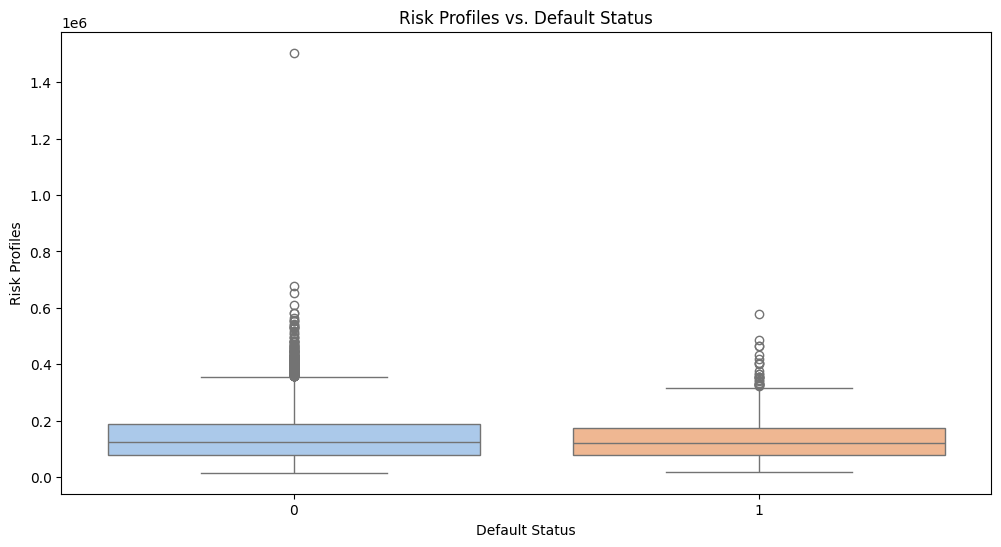

In [26]:
# Use a random sample of 10,000 rows
subset_data = merged_data.sample(n=10000, random_state=42)

# Calculate risk profiles and visualize
subset_data['RISK_PROFILE'] = subset_data[risk_features].mean(axis=1)
plt.figure(figsize=(12, 6))
sns.boxplot(y='RISK_PROFILE', x='TARGET', data=subset_data, palette='pastel')
plt.title('Risk Profiles vs. Default Status')
plt.xlabel('Default Status')
plt.ylabel('Risk Profiles')
plt.show()


2. Identifying Segments with Higher Default Risk Based on Portfolio Characteristics:

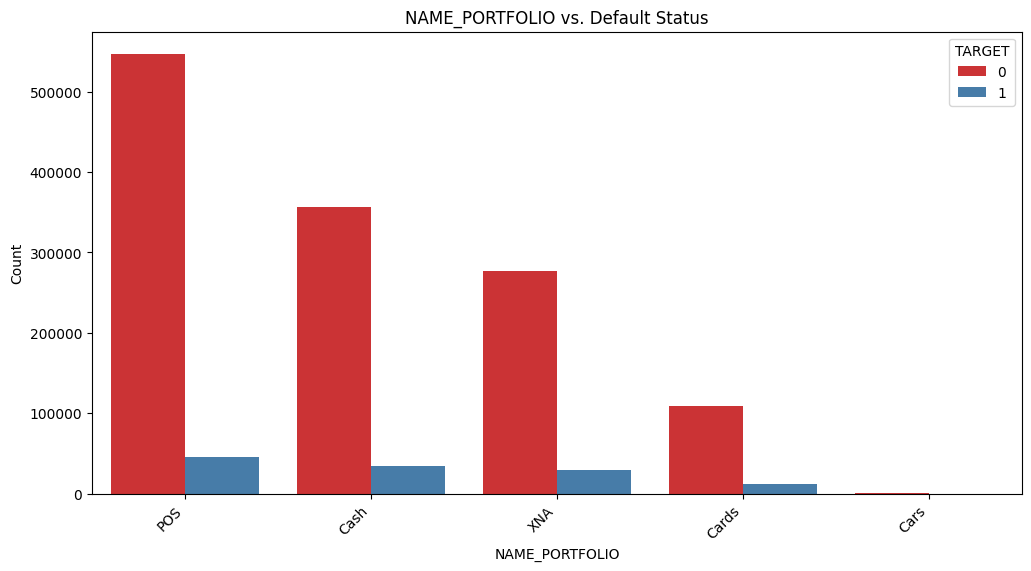

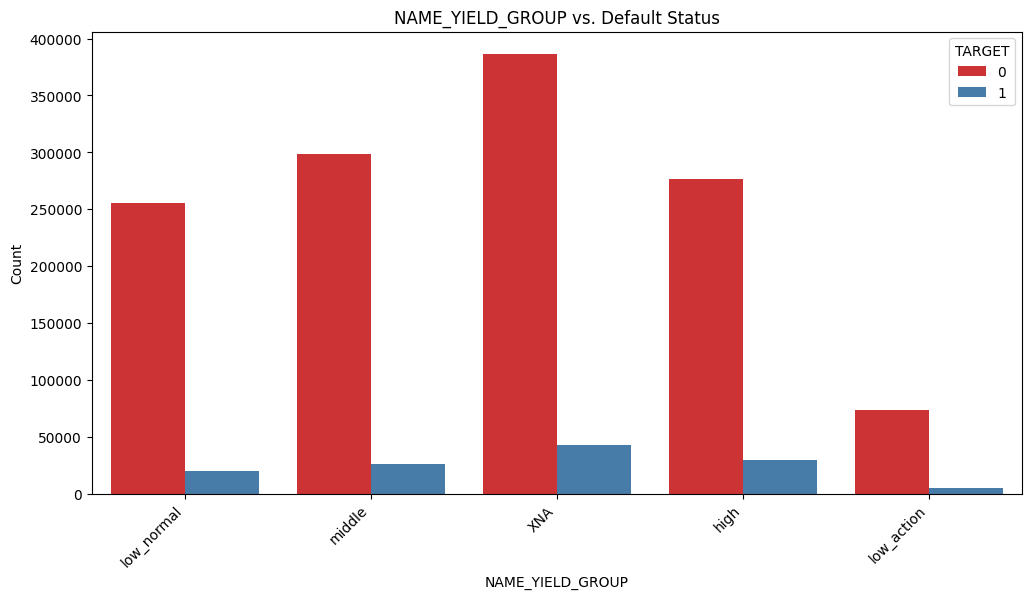

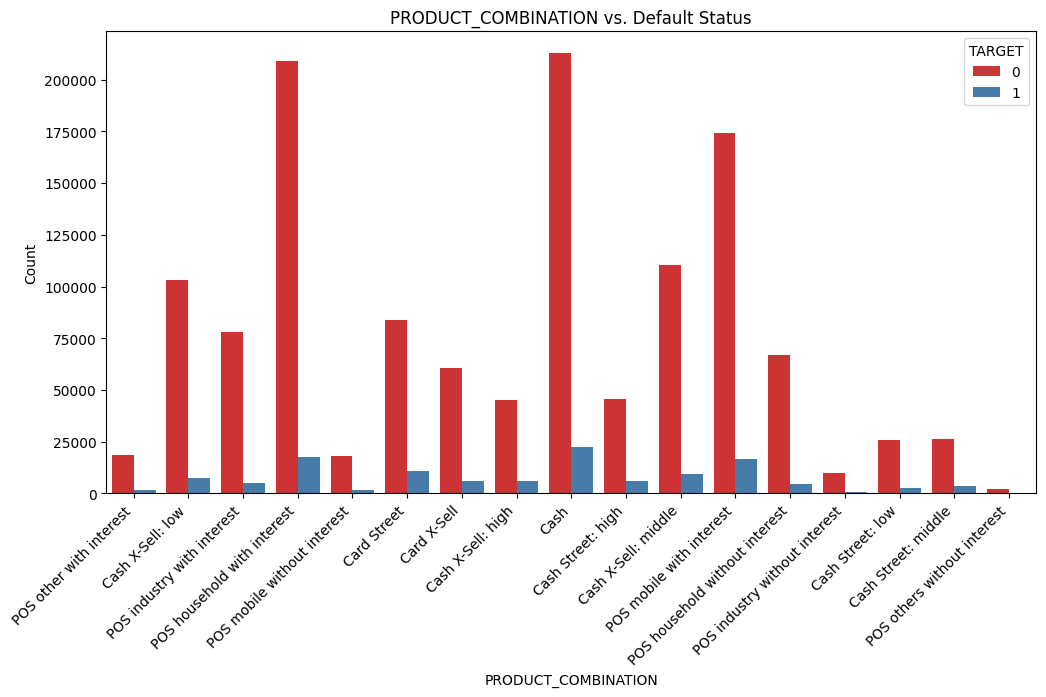

In [27]:
# Analyze portfolio characteristics and default risk
portfolio_features = ['NAME_PORTFOLIO', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION']

for feature in portfolio_features:
    plt.figure(figsize=(12, 6))
    sns.countplot(x=feature, hue='TARGET', data=merged_data, palette='Set1')
    plt.title(f'{feature} vs. Default Status')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.show()


3. Trends or Patterns in Default Rates Over Time:

C:\Users\HP\AppData\Local\Temp\ipykernel_13640\821831491.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='DAYS_DECISION', y='TARGET', data=merged_data, ci=None)


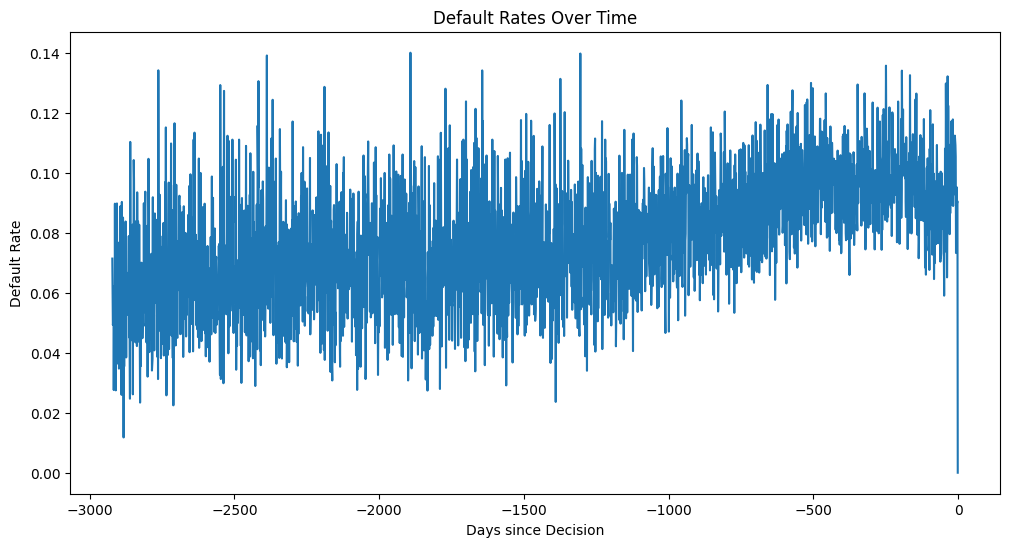

In [28]:
# Analyze trends in default rates over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='DAYS_DECISION', y='TARGET', data=merged_data, ci=None)
plt.title('Default Rates Over Time')
plt.xlabel('Days since Decision')
plt.ylabel('Default Rate')
plt.show()
